In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from numba import jit
from timeit import default_timer as timer
from dask import array as da
import dask
from dask.distributed import Client

## Naive Implementation

In [ ]:
def compute_mandelbrot(c, max_iters, threshold):
    z = 0
    for n in range(max_iters):
        if abs(z) > threshold:
            return n
        else:
            z = z**2 + c
    return  max_iters # return max_iters if the point doesn't diverge after max_iters iterations

def mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    
    mset = np.zeros((p_im, p_re)) # create an array to store the mandelbrot set
    
    for i in range(p_im): # rows (y-axis)
        for j in range(p_re): # columns (x-axis)
            c = re[j] +1j * im[i] # create a starting point
            mset[i, j] = compute_mandelbrot(c, max_iters, threshold) # store the number of iterations before diverge
    return mset

In [ ]:
p_re = 5000 # number of points in the real part
p_im = 5000 # number of points in the imaginary part
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
# outputdir = "miniproject/output"
# os.makedirs(outputdir, exist_ok=True)

print("Computing Mandelbrot set...")
start_time = timer()
mset = mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold)
end_time = timer()
print(f"Execution time: {end_time - start_time}s")

plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()
# plt.imsave(os.path.join(outputdir, f"{os.path.basename(__file__).split(".")[0]}_{max_iters}_iters.pdf"), mset)

## Using Multiprocessing

This implementation uses a mixture of JIT and multiprocessing. The multiprocessing is row-based, meaning it makes a list of the amount of rows in the mandelbrot set, and chunks the list according to the given chunk size. This was chosen over a pixel wise chunking, to avoid looping through the entire image to assign pixels to specific processes.

Observations show that larger batch size actually runs slower, no matter the amount of processors. This makes sense from a work balancing point of view, as the mandelbrot set is very not balanced in terms of computation required relative to the row being worked on.

One possible optimization could be to shuffle the row indicies before chunking them. This could lead to better work balancing

In [5]:
import multiprocessing as mp
import random

# @jit(nopython=True)
def compute_mandelbrot(c, max_iters, threshold):
    z = 0
    for n in range(max_iters):
        if abs(z) > threshold:
            return n
        else:
            z = z**2 + c
    return  max_iters # return max_iters if the point doesn't diverge after max_iters iterations

# @jit(nopython=True)
def process_chunk(args):
    # unpack args
    chunk, re, im, max_iters, threshold = args
    results = np.zeros((len(chunk), len(re))) # stores n amount of rows
    
    for idx, i in enumerate(chunk):
        for j in range(len(re)):
            c = re[j] +1j * im[i] # create a starting point
            results[idx, j] = compute_mandelbrot(c, max_iters, threshold)
    return (chunk, results) # return indicies that current chunk has processed

def mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, num_processors, chunk_size):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    mset = np.zeros((p_im, p_re)) # create an array to store the mandelbrot set
    
    # chunk each row (imaginary part) by chunk size
    row_idx = list(range(p_im))
    chunks = [row_idx[i:i+chunk_size] for i in range(0, p_im, chunk_size)]
    
    # pass arguments to processing function
    # TODO this could be optimized in a class implementation
    #       rather than passing arguments everytime
    args = [(chunk, re, im, max_iters, threshold) for chunk in chunks]
    
    # spawn processes
    with mp.Pool(processes=num_processors) as pool:
        results = pool.map(process_chunk, args)
    
    # merge chunked results
    for chunk_indicies, chunk_result in results:
        for idx, i in enumerate(chunk_indicies):
            mset[i,:] = chunk_result[idx, :]
    
    return mset

In [6]:
p_re = 5000 # number of points in the real part
p_im = 5000 # number of points in the imaginary part
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
num_processors = [4, 8, 12, 16]
chunk_size = [50, 100, 250, 500, 1000, 2500]

runtimes = {} # dict to store runtimes

for num_p in num_processors:
    for size in chunk_size:
        start_time = timer()
        mset = mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, num_p, size)
        runtimes[(num_p, size)] = timer() - start_time
        print(f"Processors: {num_p}, chunk size: {size}, Runtime: {timer() - start_time:.4f}s")

Processors: 4, chunk size: 50, Runtime: 38.5276s
Processors: 4, chunk size: 100, Runtime: 40.5768s
Processors: 4, chunk size: 250, Runtime: 39.7138s
Processors: 4, chunk size: 500, Runtime: 39.6617s
Processors: 4, chunk size: 1000, Runtime: 57.9014s
Processors: 4, chunk size: 2500, Runtime: 66.7045s
Processors: 8, chunk size: 50, Runtime: 46.5589s
Processors: 8, chunk size: 100, Runtime: 25.7916s
Processors: 8, chunk size: 250, Runtime: 26.4894s
Processors: 8, chunk size: 500, Runtime: 32.7715s
Processors: 8, chunk size: 1000, Runtime: 54.4233s
Processors: 8, chunk size: 2500, Runtime: 74.2890s
Processors: 12, chunk size: 50, Runtime: 21.3047s
Processors: 12, chunk size: 100, Runtime: 24.3012s
Processors: 12, chunk size: 250, Runtime: 23.5416s
Processors: 12, chunk size: 500, Runtime: 33.6640s
Processors: 12, chunk size: 1000, Runtime: 55.8034s
Processors: 12, chunk size: 2500, Runtime: 67.5244s
Processors: 16, chunk size: 50, Runtime: 20.1307s
Processors: 16, chunk size: 100, Runtime:

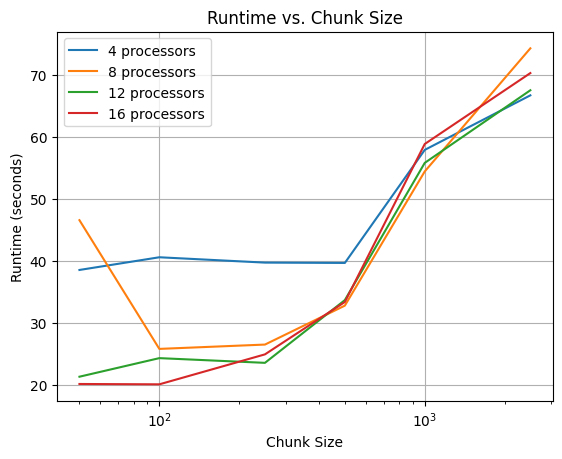

In [7]:
plt.figure()
for num_p in num_processors:
    results = [runtimes[(num_p, size)] for size in chunk_size]
    plt.plot(chunk_size, results, label=f"{num_p} processors")

plt.xlabel('Chunk Size')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Chunk Size')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()

## Numpy Implementation

In [4]:
def vector_compute_mandelbrot(C, max_iters, threshold):
    z = np.zeros(C.shape, dtype=complex)
    mset = np.zeros(C.shape, dtype=np.uint16) # array to store number of iterations before divergence
    
    for _ in tqdm(range(max_iters), desc="Computing Mandelbrot set"):
        mask = np.abs(z) <= threshold
        z[mask] = z[mask]**2 + C[mask] # perform operation on points that have not diverged
        mset += mask # add +1 to all points with true in the mask
    return mset

def vector_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    C = re[np.newaxis, :] + 1j * im[:, np.newaxis] # create axis across columns for real part and rows for imaginary part
    
    mset = vector_compute_mandelbrot(C, max_iters, threshold)
    return mset

Computing Mandelbrot set: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Execution time: 18.003738183000678s


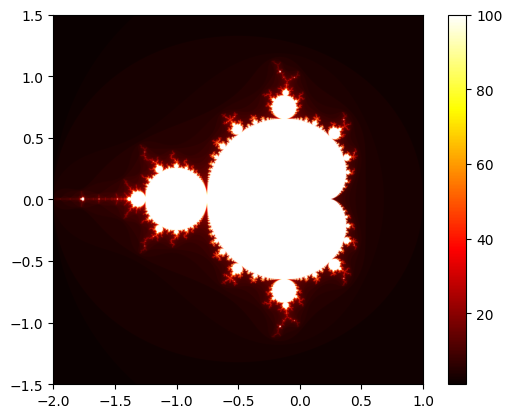

In [5]:
p_re = 5000
p_im = 5000
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
# outputdir = "miniproject/output"
# os.makedirs(outputdir, exist_ok=True)

start_time = timer()
mset = vector_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold)
end_time = timer()
print(f"Execution time: {end_time - start_time}s")


plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()
# plt.imsave(os.path.join(outputdir, f"{os.path.basename(__file__).split(".")[0]}_{max_iters}_iters.pdf"), mset)

## Dask Implementation - Local

In [ ]:
def dask_compute_mandelbrot(C, max_iters, threshold):
    z = np.zeros(C.shape, dtype=complex) # populate z with starting points
    mset = np.zeros(C.shape, dtype=np.uint16) # NOTE uint16 may be too small for large max_iters
    
    for _ in range(max_iters):
        # iterate points which didn't diverge, where mask is true
        mask = np.abs(z) <= threshold
        z[mask] = z[mask]**2 + C[mask]
        mset[mask] += 1
    return mset

def dask_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, chunk_size):
    # chunk size can differ for real and imaginary part
    re = da.linspace(re_min, re_max, p_re, chunk_size)
    im = da.linspace(im_min, im_max, p_im, chunk_size)

    # create complex plane
    x, y = da.meshgrid(re, im, indexing="xy")
    C = x + 1j * y
    
    # using map_blocks to fix memory issues
    mset = da.map_blocks(dask_compute_mandelbrot, C, max_iters, threshold, dtype=np.uint16)
    
    return mset

In [ ]:
p_re = 5000
p_im = 5000
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
chunk_size = [50, 100, 250, 500, 1000, 2500]

results = {}

client = Client(n_workers=16, memory_limit="10GB") # start local cluster
# print(client)
print("Computing Mandelbrot...")
for size in chunk_size:
    start_time = timer()
    mset = dask_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, chunk_size)
    mset = mset.compute()
    runtime = timer() - start_time
    results[size] = runtime
    print(f"Chunk size: {size}, Runtime: {runtime}")
    
client.cluster.close()
client.close()

/home/clyholm/sci_computing/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41659 instead
  warnings.warn(


Computing Mandelbrot...
Execution time: 21.487801655999647


In [19]:
client.cluster.close()
client.close()

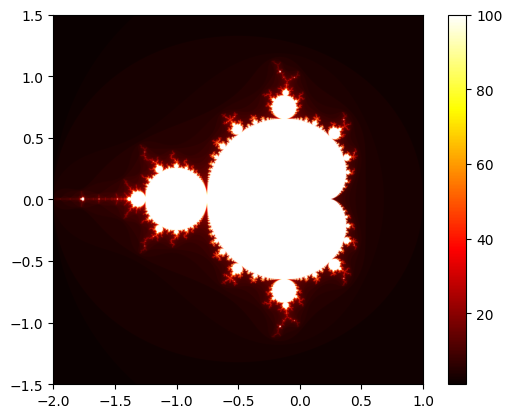

In [22]:
plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()